In [1]:
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from dyomproject.visualization import generate_confusion_matrix, generate_loss_graph
from dyomproject.config import criteo_sample_path
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
from deepctr_torch.models import DeepFM

In [3]:
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names

In [4]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]
names=["label"]+sparse_features+dense_features
data = pd.read_csv('../data/criteo/criteo_small.txt',sep='\t', 
                  names=["label"]+dense_features+sparse_features)

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

In [5]:
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [6]:
# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4 )
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [7]:
# 3.generate input data for model

train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [8]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

cuda ready...


In [9]:
# 4.Define Model,train,predict and evaluate
model_DEEP = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=[20,20], dnn_dropout=0.3, task='binary',device=device)
model_DEEP.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )
model_FM = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=[],task='binary',device=device)
model_FM.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

In [10]:
history_DEEP = model_DEEP.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
history_FM = model_FM.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

cuda:0
Train on 64000 samples, validate on 16000 samples, 250 steps per epoch
Epoch 1/10
5s - loss:  0.5078 - binary_crossentropy:  0.5078 - val_binary_crossentropy:  0.4677
Epoch 2/10
5s - loss:  0.3876 - binary_crossentropy:  0.3876 - val_binary_crossentropy:  0.4855
Epoch 3/10
5s - loss:  0.2636 - binary_crossentropy:  0.2636 - val_binary_crossentropy:  0.5611
Epoch 4/10
5s - loss:  0.2006 - binary_crossentropy:  0.2005 - val_binary_crossentropy:  0.6032
Epoch 5/10
5s - loss:  0.1743 - binary_crossentropy:  0.1742 - val_binary_crossentropy:  0.6490
Epoch 6/10
5s - loss:  0.1587 - binary_crossentropy:  0.1587 - val_binary_crossentropy:  0.6820
Epoch 7/10
5s - loss:  0.1480 - binary_crossentropy:  0.1479 - val_binary_crossentropy:  0.7196
Epoch 8/10
5s - loss:  0.1404 - binary_crossentropy:  0.1403 - val_binary_crossentropy:  0.7515
Epoch 9/10
5s - loss:  0.1347 - binary_crossentropy:  0.1346 - val_binary_crossentropy:  0.7772
Epoch 10/10
5s - loss:  0.1292 - binary_crossentropy:  0.1

In [11]:
pred_ans_DEEP = model_DEEP.predict(test_model_input, batch_size=256)
pred_ans_FM = model_FM.predict(test_model_input, batch_size=256)
#print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
#print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

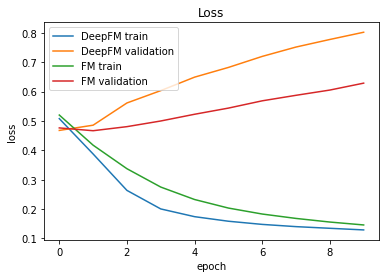

In [12]:
generate_loss_graph([history_DEEP,history_FM],["DeepFM","FM"],"binary_crossentropy")

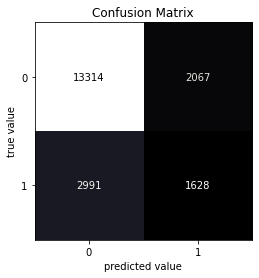

In [13]:
generate_confusion_matrix(test[target].values.flatten(),[round(x) for x in pred_ans_FM.flatten()])

In [6]:
i = [1,2,3]
k = ['a','b','c']

for z in zip(i,k):
    print(z)

(1, 'a')
(2, 'b')
(3, 'c')
